# Slicing chunks and beyond

The newest and coolest way to store data in python-blosc2 is through a `SChunk` (super-chunk) object. Here the data is split into chunks of the same size. In the past, the only way of working with it was chunk by chunk (see  tutorials-basics.ipynb), but now, python-blosc2 can retrieve, update or append data at item level (i.e. avoiding doing it chunk by chunk). To see how this works, let's first create our SChunk.

In [1]:
import blosc2
import numpy as np
import plotly.graph_objects as go
import plotly.express as px

In [2]:
path = "/home/blosc/gaia/gaia-3d-windows-2.b2nd"

In [3]:
arr = blosc2.open(path)
arr.info

{
    'blocksize': 15625,
    'clevel': 1,
    'codec': <Codec.ZSTD: 5>,
    'codec_meta': 0,
    'filters': [
        <Filter.NOFILTER: 0>,
        <Filter.NOFILTER: 0>,
        <Filter.NOFILTER: 0>,
        <Filter.NOFILTER: 0>,
        <Filter.NOFILTER: 0>,
        <Filter.SHUFFLE: 1>
    ],
    'filters_meta': [0, 0, 0, 0, 0, 0],
    'nthreads': 16,
    'splitmode': <SplitMode.ALWAYS_SPLIT: 1>,
    'typesize': 1,
    'use_dict': 0
}

{'nthreads': 16}

type,NDArray
shape,"(20000, 20000, 20000)"
chunks,"(250, 250, 250)"
blocks,"(25, 25, 25)"
dtype,uint8
cratio,20599.55
cparams,"{'codec': , 'codec_meta': 0, 'clevel': 1, 'use_dict': 0, 'typesize': 1, 'nthreads': 16, 'blocksize': 15625, 'splitmode': , 'filters': [, , , , , ], 'filters_meta': [0, 0, 0, 0, 0, 0]}"
dparams,{'nthreads': 16}


In [12]:
axis = 0
shape = arr.shape
chunks = arr.chunks
blocks = arr.blocks
#start = np.array([0, 0, 0])
start = np.array([10_000, 9_500, 9_500])
step = np.array([10, 1_000, 1_000])
nsegments = 100

In [13]:
max_factor = 4
min_factor = 1/4
incr = (max_factor - min_factor) / nsegments
incr

0.0375

In [14]:
def init_array(arr, nsegments, start, step, axis):
    arrays = []
    start_aux = start.copy()
    for j in range(nsegments):
        sl = arr[start_aux[0]: start_aux[0] + step[0], start_aux[1]:start_aux[1] + step[1], 
                 start_aux[2]:start_aux[2] + step[2]]
        arrays.append(sl)
        start_aux[axis] += step[axis]

    return arrays

In [16]:
l =[1,2,3,4]
l[:-1]

[1, 2, 3]

In [ ]:
def update_array(arr, nsegments, start, step, axis, arrays):
    new_arrays = arrays[1:]
    
    start_aux = start.copy()
    start_aux += (step[axis] * nsegments)
    for j in range(nsegments):
        sl = arr[start_aux[0]: start_aux[0] + step[0], start_aux[1]:start_aux[1] + step[1], 
                 start_aux[2]:start_aux[2] + step[2]]
        arrays.append(sl)
        start_aux[axis] += step[axis]

    return arrays

In [15]:
niter = 0
while start[axis] + step[axis] < shape[axis]:
    factor = max_factor
    if niter == 0:
        # print("abans start ", start)
        ini_arrays = init_array(arr, nsegments, start, step, axis) 
        # print("dp start ", start)
    
    for j in range(nsegments):
        #if niter < 2:
        #    print("start ", start)
        #    print("stop ", start+ step)
        #    print("factor ", factor)
        #else:
        #    break
        
        sl = arrays[j] * factor
        if j > 1:
            np_arrs = np.concatenate([np_arrs, sl], axis=axis)
        elif j == 1:
            np_arrs = np.concatenate([aux, sl], axis=axis) 

        aux = sl
        factor -= incr
        start[axis] += step[axis]
    
    img = np.sum(np_arrs, axis=axis) 
    #if niter == 2:
    #    break
    
    # -------- Create frame and save it on disk ----------------------------------------
    idx = np.indices(img.shape)
    fig = px.scatter(x=idx[0, :, :].flatten(), y=idx[1, :, :].flatten(), 
                       size=img.flatten())
                     #color=img.flatten())
    #fig.update_traces(marker_size = 1)
    # fig.show()
    fig.write_image("../frames/{0}.png".format(niter))
    # ----------------------------------------------------------------------------------
    

    niter += 1
niter

abans start  [10000  9500  9500]
dp start  [10000  9500  9500]


0

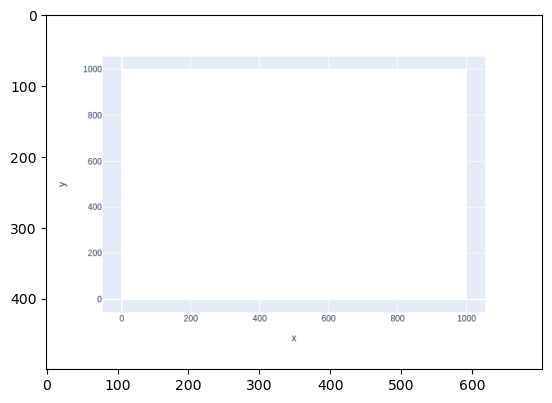

In [44]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.animation as animation

filename = "chunks_centered"
filename = "blocks_centered_overlap"
filename = "10_centered"
filename = "example"
filename = "factor_center"
frames = [] # for storing the generated images
fig = plt.figure()
for i in range(niter):
    img = plt.imread("../frames/{0}.png".format(i))
    frames.append([plt.imshow(img, animated=True)])
ani = animation.ArtistAnimation(fig, frames,
                                repeat_delay=1000)
ani.save(filename="./" + filename + ".html", writer="html")
ani.save(filename="./" + filename + ".gif", writer="pillow")

plt.show()